# Imports

In [44]:
import numpy as np
import time
import pyscf
from pyscf import dft, scf
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from pyscf import gto, lo, tools, dft 
import py3Dmol
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1. SMILES strings

## (a)

COc1cc(C=O)ccc1O

## (b)

Since nodes appear in the string in the order that they are visited by DFS, a 
different root node will produce a different order, and thus a different string.

# 2. PySCF calculations
## (a)

In [2]:
smiles = 'COc1cc(C=O)ccc1O'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

In [3]:
def show(mol):
    style = 'stick'
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=1000)
    mblock = Chem.MolToMolBlock(mol)
    view = py3Dmol.view(width=200, height=200)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()
show(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
def rks(mol):
    elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
    coordinates = mol.GetConformer().GetPositions()
    atoms = [(element, coordinate) for element, coordinate in zip(elements, coordinates)]
    
    pyscf_mole = gto.Mole()
    pyscf_mole.atom = atoms
    pyscf_mole.build()

    mf = dft.RKS(pyscf_mole)
    mf.run();

In [5]:
rks(mol)

# (b)

In [23]:
def make_water(n=3):
    # Function to create a single water molecule
    def h2o():
        mol = Chem.MolFromSmiles('O')
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        return mol
    
    # Create a new empty editable molecule
    water = Chem.RWMol()
    
    # Initialize positions
    x_offset = 100.0  # angstroms
    current_position = 0.0
    
    # Create and position 10 water molecules
    for i in range(n):
        single = h2o()
        conf = single.GetConformer()
        for atom_idx in range(single.GetNumAtoms()):
            pos = conf.GetAtomPosition(atom_idx)
            conf.SetAtomPosition(atom_idx, Chem.rdGeometry.Point3D(pos.x + current_position, pos.y, pos.z))
        water.InsertMol(single)
        current_position += x_offset

    return water

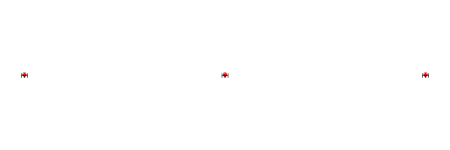

In [24]:
make_water(3)

In [28]:
# do as many as we can until the time runs out
maxtime_sec = 300
loop_start = time.time()
times = []
sizes = []
for i in range(1,50):
    if time.time() - loop_start > maxtime_sec:
        print('tl exceeded')
        break
    mol = make_water(i)
    start = time.time()
    rks(mol)
    times.append(time.time() - loop_start)
    sizes.append(i)
print(times)

converged SCF energy = -74.7370588996729
converged SCF energy = -149.473675215469
converged SCF energy = -224.207272771189
converged SCF energy = -298.934814168601
converged SCF energy = -373.675123074409
converged SCF energy = -448.407670361239
converged SCF energy = -523.151394151509
converged SCF energy = -597.879096418828
converged SCF energy = -672.607520400023
converged SCF energy = -747.360338006399
converged SCF energy = -822.077665727567


KeyboardInterrupt: 

In [42]:
def exp(x, a, b): return a * (x ** b)

In [48]:
p, cov = curve_fit(exp, sizes, times)

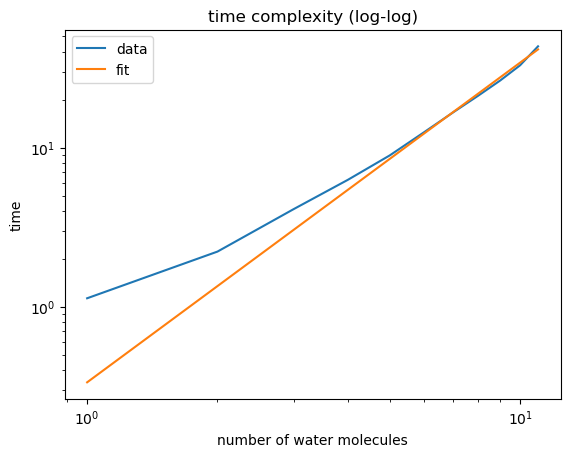

In [67]:
plt.plot(sizes, times, label='data')
plt.plot(sizes, [exp(i, *p) for i in sizes], label='fit')
plt.title('time complexity')
use_loglog = True
if use_loglog:
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    plt.title('time complexity (log-log)')
plt.legend()
plt.xlabel('number of water molecules')
plt.ylabel('time')
plt.show()